In [1]:
import numpy as np 
import pandas as pd 
import operator as op
from functools import reduce
import networkx as nx 
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
%matplotlib inline

In [2]:
class utils:
    def ncr(n, r):
        r = min(r, n-r)
        numer = reduce(op.mul, range(n, n-r, -1), 1)
        denom = reduce(op.mul, range(1, r+1), 1)
        return numer // denom

    def easy(x):
        return x.bit_length()

In [3]:
class Node:

    def __init__(self, data):

        self.left = None
        self.right = None
        self.data = data
        self.parent = None
        self.category = None
        self.level = 0
    
    def __str__(self):
        return f'data: {self.data}'

    def PreorderTraversal(self, root):
        res = []
        if root:
            res.append(root.data)
            res = res + self.PreorderTraversal(root.left)
            res = res + self.PreorderTraversal(root.right)
        return res
    
    def binary_representation(self, root):
        result = ''
        if root: 
            #if root.left == None:
            #    result += '0' + root.data
            #else:
            if root.right == None: 
                result += '0'
            else:
                result += '1'
            result += root.data
            result = result + self.binary_representation(root.left)
            result = result + self.binary_representation(root.right)
        return result
    
    def get_leaves(self, root):
        leaves = []
        if root:
            if root.right == None:
                leaves.append(root)
            leaves = leaves + self.get_leaves(root.left)
            leaves = leaves + self.get_leaves(root.right)
        return leaves
    
    def get_attr_and_category_from_leaf(self, root):
        attr_and_category = []
        while root.parent != None:
            category = root.category
            root = root.parent
            attr_and_category.append([root.data, category])
        attr_and_category = list(reversed(attr_and_category))
        return attr_and_category
        
    def replace_leaf_with_decision_node(self, attribute, default_for_0, default_for_1):
        self.data = attribute
        self.left = Node(default_for_0)
        self.left.parent = self
        self.left.category = 0
        self.left.level = self.level+1
        self.right = Node(default_for_1)
        self.right.parent = self
        self.right.category = 1
        self.right.level = self.level+1 
    
    def replace_decision_node_with_leaf(self, default):
        self.data = default
        self.left = None
        self.right = None
    
    def plot(self,root):
        G = nx.DiGraph()
         # Base CAse  
        if root is None: 
            return 

        # create an empty stack and push root to it 
        nodeStack = [] 
        nodeStack.append(root) 

        #  Pop all items one by one. Do following for every popped item 
        #   a) print it 
        #   b) push its right child 
        #   c) push its left child 
        # Note that right child is pushed first so that left 
        # is processed first */ 
        while(len(nodeStack) > 0): 

            # Pop the top item from stack and print it 
            node = nodeStack.pop() 
            label = str(node.level) + ' ' + node.data
            G.add_node(label) 
            if node.parent != None:
                parent_label = str(node.parent.level) + ' ' + node.parent.data
                G.add_edge(parent_label, label)

            # Push right and left children of the popped node 
            # to stack 
            if node.right is not None: 
                nodeStack.append(node.right) 
            if node.left is not None: 
                nodeStack.append(node.left) 
        #pos = graphviz_layout(G, prog='dot')
        #plot = nx.draw(G, pos, with_labels=False, arrows=True)
        plot = nx.draw_spring(G, with_labels=True)
        return plot

In [4]:
class DecisionTree:
    
    
    def __init__(self):
        self.X = None
        
        self.Y = None
        
        self.tree = None
        self.encode_dict = None
        
    def fit(self, X, Y):
        count = 0
        # building tree: start
        if type(X) == pd.DataFrame and type(Y) == pd.DataFrame:
            X = X.values
            Y = Y.values
        self.X = X
        self.Y = Y
        
        default = DecisionTree.median(self.Y)

        self.tree = Node(default)
        self.leaf_amount = len(self.tree.get_leaves(self.tree))
        
        #(not self.is_perfect) and
        will_continue = False
        perfect_leaves = []
        while self.leaf_amount < pow(2, self.X.shape[1]):
            
            # find unused attributes
            for _leaf in self.tree.get_leaves(self.tree):
                if _leaf not in perfect_leaves:
                    leaf = _leaf
                    break
            if leaf == None:
                break
            try:
                used_attr_and_category_list = leaf.get_attr_and_category_from_leaf(leaf)
                used_binary_attr_list = list(np.array(used_attr_and_category_list)[:,0])
                used_attr_list = self.decode(used_binary_attr_list)
                temp = np.array(used_attr_and_category_list)
                temp[:,0] = used_attr_list
                temp = temp.astype(int)
                used_attr_and_category_list = list(temp)
            except:
                used_attr_list = []
            unused_attr_list = self.get_unused_attributes_from_used_attributes(used_attr_list)
            
            default = leaf.data
            cost_list = []
            for unused_attr in unused_attr_list:
                # calculate defaults
                default_0, default_1 = self.get_default_0_and_1(used_attr_and_category_list, unused_attr)
                if default_0 == '-1' or default_1 == '-1':
                    perfect_leaves.append(leaf)
                    leaf = None
                    will_continue = True
                    break
                binary_attr = self.encode([*used_attr_list, unused_attr]).pop()
                leaf.replace_leaf_with_decision_node(binary_attr, default_0, default_1)
                cost = self.total_cost()
                cost_list.append(cost)
                leaf.replace_decision_node_with_leaf(default)
            if will_continue:
                will_continue = False
                continue
            if cost_list == []:
                perfect_leaves.append(leaf)
                continue
            min_index = np.argmin(cost_list)
            min_attr = unused_attr_list[min_index]
            # REFACTOR THIS 
            default_0, default_1 = self.get_default_0_and_1(used_attr_and_category_list, min_attr)
            binary_attr = self.encode([*used_attr_list, min_attr]).pop()
            leaf.replace_leaf_with_decision_node(binary_attr, default_0, default_1)
            self.leaf_amount = len(self.tree.get_leaves(self.tree))
            leaf = None
        # building tree: end
        # pruning tree: start
        will_not_prune = []
        first_parent = None
        while len(will_not_prune) < self.leaf_amount / 2:
            leaves = self.tree.get_leaves(self.tree)
            for _leaf in leaves:
                if _leaf.parent not in will_not_prune:
                    if _leaf.parent.left in leaves and _leaf.parent.right in leaves:
                        leaf = _leaf
            if leaf == None:
                print('gracefully exiting')
                break
                    
            parent = leaf.parent
            left_child_data = parent.left.data
            right_child_data = parent.right.data
            parent_data = parent.data
            current_cost = self.total_cost()
            parent_used_attr_and_category_list = parent.get_attr_and_category_from_leaf(parent)
            if parent_used_attr_and_category_list == []:
                will_not_prune.append(parent)
                continue
            used_binary_attr_list = list(np.array(parent_used_attr_and_category_list)[:,0])
            used_attr_list = self.decode(used_binary_attr_list)
            temp = np.array(parent_used_attr_and_category_list)
            temp[:,0] = used_attr_list
            temp = temp.astype(int)
            parent_used_attr_and_category_list = list(temp)
            default = self.get_default(parent_used_attr_and_category_list)
            parent.replace_decision_node_with_leaf(default)
            new_cost = self.total_cost()
            if new_cost < current_cost:
                print(new_cost, current_cost, 'succesfully pruned')
            else:
                parent.replace_leaf_with_decision_node(parent_data, left_child_data, right_child_data)
                will_not_prune.append(parent)
            self.leaf_amount = len(self.tree.get_leaves(self.tree))
            leaf = None
        # pruning tree: end
        print('Exited while loop')
        
    def get_default_0_and_1(self, used_attr_and_category_list, unused_attr):
        filtr = self.get_filter_from_attr_and_category(used_attr_and_category_list)
        filtr_0, filtr_1 = self.unused_attribute_filters(filtr, unused_attr)
        default_0 = DecisionTree.median(self.Y[filtr_0])
        default_1 = DecisionTree.median(self.Y[filtr_1])
        return default_0, default_1
    
    def get_default(self, used_attr_and_category_list):
        filtr = self.get_filter_from_attr_and_category(used_attr_and_category_list)
        default = DecisionTree.median(self.Y[filtr])
        return default
                
    def get_filter_from_attr_and_category(self, attr_and_category):
        filtr = np.full(self.X.shape[0], True, dtype=bool)
        for attr, category in attr_and_category:
            filtr = filtr & (self.X[:, attr] == category)
        return filtr
    
    def unused_attribute_filters(self, filtr,  unused_attr):
        filtr_0 = filtr & (self.X[:, unused_attr] == 0)
        filtr_1 = filtr & (self.X[:, unused_attr] == 1)
        return filtr_0 , filtr_1
    
    def communication_cost(self):
        # Dict {00: sunny, 01: warm, 10: cold, 11: freezing,  001:burning}
        # cost of attribute names
        # decision node indication
        # leave indication
        # default class
        return len(self.tree.binary_representation(self.tree))
    
    @staticmethod
    def exception_cost(n, k):
        # use ceil
        n = n
        k = k
        b = (n+1) / 2
        bit_amount_for_k = np.ceil(np.log2(b+1))
        #bit_amount_for_exception_location = np.ceil(np.log2(np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n-k))))
        bit_amount_for_exception_location = utils.easy(utils.ncr(n,k))
        return bit_amount_for_k + bit_amount_for_exception_location
    
    def total_exception_cost(self):
        total_exception_cost = 0
        for leaf in self.tree.get_leaves(self.tree):
            
            used_attr_and_category_list = leaf.get_attr_and_category_from_leaf(leaf)
            used_binary_attr_list = list(np.array(used_attr_and_category_list)[:,0])
            used_attr_list = self.decode(used_binary_attr_list)
            temp = np.array(used_attr_and_category_list)
            temp[:,0] = used_attr_list
            temp = temp.astype(int)
            used_attr_and_category_list = list(temp)
            filtr = self.get_filter_from_attr_and_category(used_attr_and_category_list)
            n = self.Y[filtr].shape[0]
            median = np.median(self.Y[filtr])
            if median == 0.5:
                median = np.random.choice([0,1])
            exception = 1 - median
            k = self.Y[filtr][self.Y[filtr] == exception].shape[0]
            exception_cost = DecisionTree.exception_cost(n,k)
            total_exception_cost += exception_cost
        return total_exception_cost
    
    def total_cost(self):
        return self.communication_cost() + self.total_exception_cost()
    
    def encode(self, actual_attribute_indexes):
        relative_binary_attribute_indexes = []
        used_indexes = []
        unused_attribute_amount = self.X.shape[1] - len(actual_attribute_indexes)
        for i, value in enumerate(actual_attribute_indexes):
            how_many_smaller = len([j for j in used_indexes if j < value])
            used_indexes.append(actual_attribute_indexes[i])
            relative_binary_attribute_indexes.append(
                DecisionTree.integer_to_binary(
                    actual_attribute_indexes[i] - how_many_smaller,
                    DecisionTree.min_bit_amount(len(actual_attribute_indexes) - i + unused_attribute_amount)))
        return relative_binary_attribute_indexes
    
    def decode(self, binary_indexes):
        relative_indexes = []
        for index in binary_indexes:
            relative_indexes.append(DecisionTree.binary_to_integer(index))
        return self.get_actual_attribute_indexes(relative_indexes)

    def is_perfect(self):
        return np.all(np.equal(Y, self.predict(self.X)))
    
    def predict(self, X):
        Y_head = []
        if type(X) == pd.DataFrame and type(Y) == pd.DataFrame:
            X = X.values
        leaves = self.tree.get_leaves(self.tree)
        for row in X:
            root = self.tree
            _X = X.copy()
            while root not in leaves:
                binary_attr = root.data
                attr = self.decode([binary_attr])[0]
                switch = row[attr]
                if switch == 0:
                    root = root.left
                if switch == 1:
                    root = root.right
                #print('attr:', attr)
                #print('switch:', switch)
            row_prediction = root.data
            Y_head.append(row_prediction)
        return np.array(Y_head).astype(int)
            
            
        # returns Y_head
        pass
    
    
    def get_actual_attribute_indexes(self, currently_used_attributes):        
        actual_used_attribute_indexes= []
        temporary_attribute_indexes= list(range(self.X.shape[1]))
        for i in range(len(currently_used_attributes)):            
            actual_used_attribute_indexes.append(temporary_attribute_indexes[currently_used_attributes[i]])
            del temporary_attribute_indexes[currently_used_attributes[i]]
        return actual_used_attribute_indexes
    
    def get_relative_attribute_indexes(self, attribute_indexes):
        pass
    
    def get_unused_attributes_from_used_attributes(self, used_attributes):
        attr_amount = self.X.shape[1]
        attr_list = range(attr_amount)
        unused_attr_list = [i for i in attr_list if i not in used_attributes]
        return unused_attr_list
        
    @staticmethod
    def binary_to_integer(binary_value):
        return int(binary_value,2) 

    @staticmethod
    def is_power2(num):
    # states if a number is a power of two

        return num != 0 and ((num & (num - 1)) == 0)
    @staticmethod
    def integer_to_binary(integer_value, code_length):
        return np.binary_repr(integer_value, width=code_length)
    
    
    @staticmethod
    def min_bit_amount(num):
        x = 1
        while pow(2, x) < num:
            x += 1
        return x
    
    @staticmethod
    def median(array):
        median = np.median(array)
        if median == 0.5:
            median = np.random.choice([0,1])
        try:
            median = str(int(median))
        except: 
            median = str(-1)
        return median
    
    def acc_score(self, Y, Y_head):
        return (Y_head == Y).sum() / Y_head.shape[0]
        
    def plot(self):
        pass
        

In [5]:
row_amount = 50000
train_split = int(row_amount * 0.7)
feature_amount = 6
X = np.random.randint(0,2,(row_amount,feature_amount))
Y = X.sum(axis=1)
Y[Y < feature_amount/3], Y[Y >= feature_amount/3] = 1, 0 
#Y = np.random.randint(0,2,(row_amount,1))
Z = np.random.randint(0,2,(row_amount // 4,feature_amount))

In [6]:
tree = DecisionTree()

In [7]:
tree.fit(X[:train_split], Y[:train_split])

895.0 908.0 succesfully pruned
882.0 895.0 succesfully pruned
868.0 882.0 succesfully pruned
855.0 868.0 succesfully pruned
843.0 855.0 succesfully pruned
829.0 843.0 succesfully pruned
813.0 829.0 succesfully pruned
800.0 813.0 succesfully pruned
787.0 800.0 succesfully pruned
773.0 787.0 succesfully pruned
760.0 773.0 succesfully pruned
747.0 760.0 succesfully pruned
733.0 747.0 succesfully pruned
717.0 733.0 succesfully pruned
700.0 717.0 succesfully pruned
687.0 700.0 succesfully pruned
674.0 687.0 succesfully pruned
660.0 674.0 succesfully pruned
647.0 660.0 succesfully pruned
634.0 647.0 succesfully pruned
620.0 634.0 succesfully pruned
604.0 620.0 succesfully pruned
591.0 604.0 succesfully pruned
578.0 591.0 succesfully pruned
564.0 578.0 succesfully pruned
551.0 564.0 succesfully pruned
538.0 551.0 succesfully pruned
525.0 538.0 succesfully pruned
511.0 525.0 succesfully pruned
498.0 511.0 succesfully pruned
485.0 498.0 succesfully pruned
471.0 485.0 succesfully pruned
455.0 47

In [8]:
tree.tree.binary_representation(tree.tree)

'10011000110101100110010011100100001011110010000001001101010010000000010101001001010010000000000'

In [9]:
predictions = tree.predict(Z)
predictions

array([0, 0, 0, ..., 0, 1, 0])

In [10]:
predictions = tree.predict(X[train_split:])
predictions

array([0, 1, 1, ..., 0, 0, 0])

In [11]:
predictions.shape[0]

15000

In [12]:
(predictions == Y[train_split:]).sum() / predictions.shape[0]

0.7093333333333334

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(Y[train_split:], predictions)

0.7093333333333334

In [15]:
tree.acc_score(Y[train_split:], predictions)

0.7093333333333334

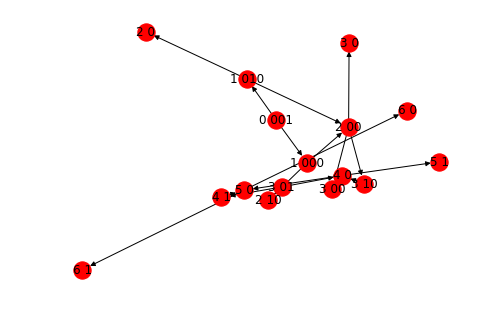

In [16]:
tree.tree.plot(tree.tree)